We multiply a signal vector/matrix
(containing an indicator of whether we are entering or closing a position) by the vector of returns. By
doing so, we calculate the performance over a certain period of time.


In [11]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = yf.download("AAPL", start="2016-01-01", end="2021-12-31", progress=False)

df = df[["Adj Close"]]

In [ ]:
# Calculate the log returns and the 20-day SMA of the close prices:
df["log_rtn"] = df["Adj Close"].apply(np.log).diff(1)
df["sma_20"] = df["Adj Close"].rolling(window=20).mean()

# To calculate the SMA, we used the rolling method.
# This method is primarily used for performing rolling window calculations on time-series or sequential data.

In [ ]:
# Create a position indicator:
df["position"] = (df["Adj Close"] > df["sma_20"]).astype(int) # information on whether we have an open position (long only, 1) or not (0)
# we enter the position when the close price is above the 20-day SMA

# Using the following snippet, we count how many times we entered a long position:
sum((df["position"] == 1) & (df["position"].shift(1) == 0)) #56

Text(0.5, 1.0, 'Preview of our strategy in 2021')

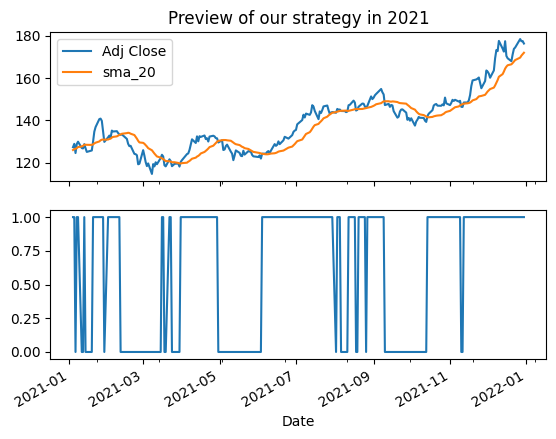

In [12]:
# Visualize the strategy over 2021 only:
fig, ax = plt.subplots(2, sharex=True)
df.loc["2021", ["Adj Close", "sma_20"]].plot(ax=ax[0])
df.loc["2021", "position"].plot(ax=ax[1])
ax[0].set_title("Preview of our strategy in 2021")

In [ ]:
# in the periods when the close price is above the 20-day SMA, we do have an open position.

In [ ]:
# Calculate the strategy’s daily and cumulative returns:
df["strategy_rtn"] = df["position"].shift(1) * df["log_rtn"]
df["strategy_rtn_cum"] = (df["strategy_rtn"].cumsum().apply(np.exp))

# To calculate the daily return, we multiplied the log return of that day with the
# shifted position flag. The position vector is shifted by 1 to avoid the look-ahead bias. In other words,
# the flag is generated using all the information up to and including time t. We can only use that information
# to open a position on the next trading day, that is, at time t+1.

# Then, we used the cumsum method to calculate the cumulative sum of the log returns.
# Lastly, we applied the exponent function using the apply method.

In [15]:
# Add the buy-and-hold strategy for comparison:
df["bh_rtn_cum"] = df["log_rtn"].cumsum().apply(np.exp)

# we calculated the cumulative returns of a buy-and-hold strategy.

In [16]:
df.tail(10)

,Adj Close,log_rtn,sma_20,position,strategy_rtn,strategy_rtn_cum,bh_rtn_cum
Date,,,,,,,
2021-12-16,170.538422,-0.040056,165.466125,1,-0.040056,7.794218,7.103083
2021-12-17,169.429611,-0.006523,166.122994,1,-0.006523,7.743541,7.056900
2021-12-20,168.053497,-0.008155,166.578396,1,-0.008155,7.680648,6.999584
2021-12-21,171.261124,0.018907,167.170914,1,0.018907,7.827248,7.133185
2021-12-22,173.884644,0.015203,167.875304,1,0.015203,7.947152,7.242457
2021-12-23,174.518250,0.003637,168.585138,1,0.003637,7.976110,7.268847
2021-12-27,178.527786,0.022715,169.749386,1,0.022715,8.159360,7.435848
2021-12-28,177.498169,-0.005784,170.692366,1,-0.005784,8.112303,7.392963
2021-12-29,177.587265,0.000502,171.389330,1,0.000502,8.116375,7.396674


<Axes: title={'center': 'Cumulative returns'}, xlabel='Date'>

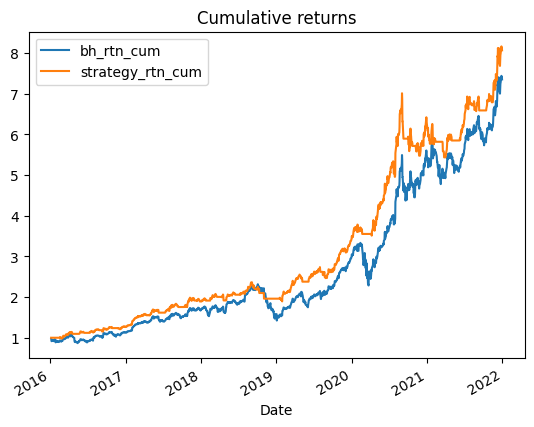

In [17]:
# Plot the strategies’ cumulative returns:
(df[["bh_rtn_cum", "strategy_rtn_cum"]].plot(title="Cumulative returns"))

The initial conclusion could be
that the simple strategy outperformed the buy-and-hold strategy over the considered time period.
However, this form of a simplified backtest does not consider quite a lot of crucial aspects (for example, trading using the close price, it assumes lack of slippage and transaction costs, and so on) that
can dramatically change the final outcome.

Taking costs alone into account:

In [ ]:
# For simplicity, we assume that the transaction costs are 1%

In [18]:
# Calculate daily transaction costs:
TRANSACTION_COST = 0.01
df["tc"] = df["position"].diff(1).abs() * TRANSACTION_COST

# We calculated if there is a change in our portfolio (absolute value, as we can enter or exit a position) and then
# multiplied that value by the transaction costs expressed as a percentage.

In [19]:
# Calculate the strategy’s performance accounting for transaction costs:
df["strategy_rtn_cum_tc"] = ((df["strategy_rtn"] - df["tc"]).cumsum().apply(np.exp))

<Axes: title={'center': 'Cumulative returns'}, xlabel='Date'>

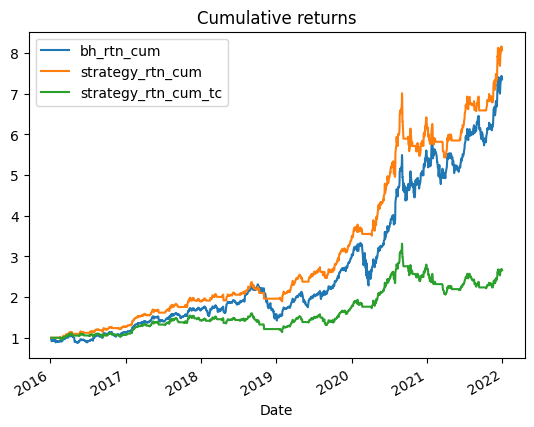

In [20]:
# Plot the cumulative returns of all the strategies:
STRATEGY_COLS = ["bh_rtn_cum", "strategy_rtn_cum",
 "strategy_rtn_cum_tc"]
(
 df
 .loc[:, STRATEGY_COLS]
 .plot(title="Cumulative returns")
)

After accounting for transaction costs, the performance decreased significantly and is worse than
that of the buy-and-hold.